## Regularization


In [1]:
#import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

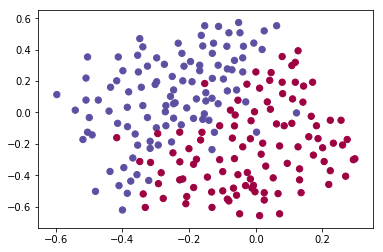

In [2]:
#load the datasets
train_X, train_Y, test_X, test_Y = load_2D_dataset()

### 1. Non-regularized Model

In [7]:
def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
    grads = {}
    costs = []
    m = X.shape[0]
    layer_dims = [X.shape[0],20,3,1]
    
    parameters = initialize_parameters(layer_dims)
    
    for i in range(num_iterations):
        #forward propagation
        if keep_prob==1:
            a3, cache = forward_propagation(X, parameters)
        else:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        #Cost Function
        if lambd==0:
            cost = compute_cost(a3,Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        if lambd==0 and keep_prob==1:
            grads = backward_propagation(X, Y, cache)
        elif lambd!=0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob<1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
            
        #update the parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i%10000==0:
            print("Cost after iteration {}:{}".format(i,cost))
            costs.append(cost)
        
    #plot the cost
    plt.plot(costs)
    plt.ylabel("cost")
    plt.xlabel("iterations")
    plt.title("Learning Rate =%s"%learning_rate)
    plt.show()
    
    return parameters

Cost after iteration 0:0.6557412523481002
Cost after iteration 10000:0.163299875257242
Cost after iteration 20000:0.13851642423266128


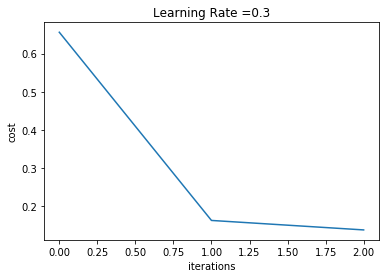

on training set:
Accuracy: 0.9478672985781991
on testing set:
Accuracy: 0.915


In [8]:
#train the model without the regularizations
parameters = model(train_X, train_Y)
print("on training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("on testing set:")
predictions_test = predict(test_X, test_Y, parameters)

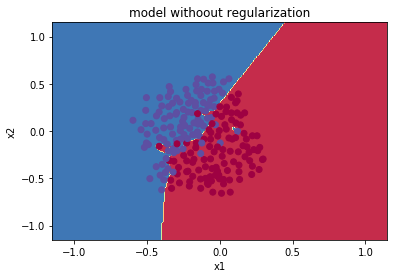

In [9]:
plt.title("model withoout regularization")
axes = plt.gca()
axes.set_xlim([-1.15,1.15])
axes.set_ylim([-1.15,1.15])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

- this is the baseline model which is overfitting.

### 2. L2-Regularization

In [16]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_loss = compute_cost(A3, Y)
    L2_regularized_cost = (lambd/(2*m))*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))
    
    cost = cross_entropy_loss + L2_regularized_cost
    return cost

In [17]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1,A1,W1,b1,Z2,A2,W2,b2,Z3,A3,W3,b3) = cache
    
    dZ3 = A3-Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = 1./m * np.dot(dZ1, X.T) +  (lambd/m)*W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Cost after iteration 0:0.6974484493131264
Cost after iteration 10000:0.2684918873282239
Cost after iteration 20000:0.26809163371273004


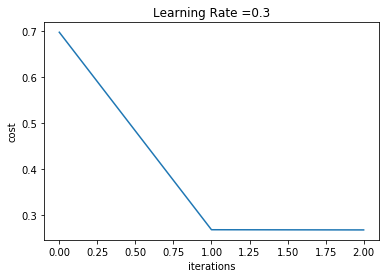

on training set:
Accuracy: 0.9383886255924171
on testing set:
Accuracy: 0.93


In [18]:
#train the model the regularizations
parameters = model(train_X, train_Y, lambd=0.7)
print("on training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("on testing set:")
predictions_test = predict(test_X, test_Y, parameters)

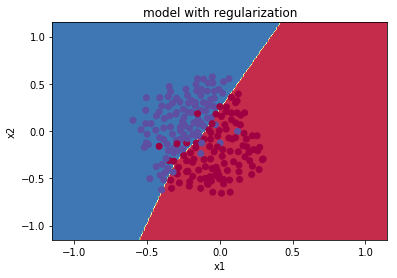

In [19]:
plt.title("model with regularization")
axes = plt.gca()
axes.set_xlim([-1.15,1.15])
axes.set_ylim([-1.15,1.15])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

### 3. Dropout

In [24]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = D1<keep_prob
    A1 = A1*D1
    A1 = A1/keep_prob #scale the value of neurons that haven't shut down
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = D2<keep_prob
    A2 = A2*D2
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3,A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    return A3, cache
    
    

In [25]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3-Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2*D2
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
    

Cost after iteration 0:0.6948875806782182
Cost after iteration 10000:0.4434359255635764
Cost after iteration 20000:0.4434134491001816


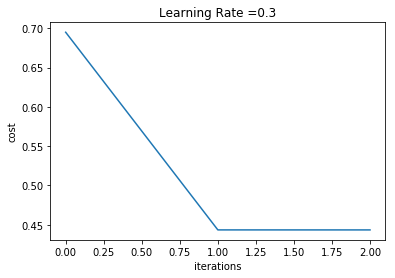

on training set:
Accuracy: 0.8720379146919431
on testing set:
Accuracy: 0.905


In [26]:
#train the model the dropout
parameters = model(train_X, train_Y, keep_prob=0.3)
print("on training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("on testing set:")
predictions_test = predict(test_X, test_Y, parameters)

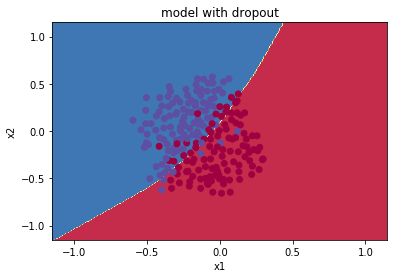

In [27]:
plt.title("model with dropout")
axes = plt.gca()
axes.set_xlim([-1.15,1.15])
axes.set_ylim([-1.15,1.15])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)